In [9]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity,
    outcome_sensitivity,
    bootstrapped_explanation_consistency,
    cross_method_explanation_consistency,
    cross_method_outcome_consistency,
    outcome_fidelity,
)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlresearch.utils import check_random_states, set_matplotlib_style
from xai_ranking.utils import scores_to_ordering

RNG_SEED = 42

In [10]:
set_matplotlib_style(font_size=16, use_latex=True)

In [11]:
# # Set up ranker for the moving company dataset:
# X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
# qids_train = X.index.value_counts().to_numpy()

# model = LGBMRanker(
#     objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
# )
# model.fit(
#     X=X,
#     y=ranks,
#     group=qids_train,
# )

In [12]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "done": True,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "done": True,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "done": True,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True,
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True,
    },
    # {
    #     "name": "Moving Company",
    #     "data": preprocess_movers_data(fetch_movers_data(test=True)),
    #     "scorer": model.predict,
    #     "done": True,
    # },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "rank_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank",
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "rank_score_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank_score",
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank",
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "score",
        },
        "done": True,
    },
]

In [13]:
# def read_results_from_files():
#     return_dict = {}
#     for cur_dataset in datasets:
#         return_dict[cur_dataset["name"]] = {}
#         for cur_xai_method in xai_methods:
#             return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
#             for iteration in range(cur_xai_method["iterations"]):
#                 fname = (
#                     f"results/time-experiment-"
#                     f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
#                 )
#                 if os.path.isfile(fname):
#                     (
#                         return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
#                             pd.read_csv(fname, index_col=0)
#                         )
#                     )
#     return return_dict

In [14]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = f"results/time/time-experiment-" f"{cur_dataset['name']}.csv"
                if os.path.isfile(fname):
                    temp = pd.read_csv(fname, index_col=0)
                    temp = temp[temp["approach"] == cur_xai_method["name"]]
                    if not temp.empty:
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            temp
                        )
    return return_dict

In [15]:
results = read_results_from_files()

In [16]:
# results

# Make speedup/fidelity plots

In [63]:
df = pd.read_excel("results/all-time-experiments-results-compiled.xlsx")
df["parameter"] = df["parameter"].str.replace("_", " ")
df.rename(columns={"Fidelity": "fidelity"}, inplace=True)
df.dropna(subset=["parameter_value"], inplace=True)
# df.parameter_value = df.parameter_value.astype(int)

In [64]:
df["parameter"].unique()

array(['coalition size', 'sample size'], dtype=object)

In [99]:
colors = {
    "rank": "#4f81bd",
    "score": "#c0504d",
    "pairwise": "#9bbb59",
}

# Speedup vs sample size
# dataset = "ATP"
# parameter = "coalition size"
# target = "speedup"


for dataset, (target, parameter) in product(
    df["dataset"].unique(),
    [
        ("speedup", "sample size"),
        ("speedup", "coalition size"),
        ("fidelity", "coalition size"),
    ],
):
    df_masked = df[(df["dataset"] == dataset) & (df["parameter"] == parameter)].copy()

    fig, ax = plt.subplots(figsize=(5, 2.5))
    sns.lineplot(
        data=df_masked,
        x="parameter_value",
        y=target,
        hue="approach",
        palette=colors,
        marker="o",
        markeredgewidth=0.0,
        ax=ax,
    )
    plt.legend(
        bbox_to_anchor=(0.45, -0.25),
        ncol=len(df_masked["approach"].unique()),
        loc="upper center",
        columnspacing=0.8,
        title="",
    )
    plt.xlabel(parameter)
    plt.grid(axis="x")
    if df_masked["parameter_value"].max() > 1000:
        ticks = df_masked["parameter_value"].sort_values().unique().tolist()
        ticks = ticks[:1] + ticks[4:]
        plt.xticks(ticks)
    else:
        plt.xticks(df_masked["parameter_value"])
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if target == "speedup":
        plt.ylim(0, int(df_masked[target].max() * 1.2) + 1)
    else:
        plt.ylim(0.8, 1.05)

    plt.margins(y=0)

    # plt.tight_layout()
    plt.savefig(
        f"results/NEW/{target.title()}vs{parameter.split()[0].title()}_{dataset}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )
    plt.close()

# Make dataframe for paper plots

In [102]:
new_rcparams = {
    "axes.spines.left": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
}
plt.rcParams.update(new_rcparams)

In [18]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# Make new dataframe that contains everything
df_all = pd.DataFrame()

for dataset in datasets:
    # Get number of features and samples
    n_samples = dataset["data"][0].shape[0]
    n_features = dataset["data"][0].shape[1] - 1

    # Rename etc
    error = []
    # columns = ["dataset", "total samples", "QoI", "pairwise", "parameter", "# samples", "# coalitions",
    #           "time", "kendall", "jaccard", "euclidean", "fidelity"]
    columns = [
        "dataset",
        "total samples",
        "QoI",
        "pairwise",
        "parameter",
        "# samples",
        "# coalitions",
        "time",
        "distance metric",
        "agreement",
        "fidelity",
    ]
    for method in methods:
        # Process saved file
        for index, row in results[dataset["name"]][method][0].iterrows():
            if row["approach"] == "rank_rank":
                qoi = "rank"
                pairwise = False
            elif row["approach"] == "rank_score_rank_score":
                qoi = "score"
                pairwise = False
            elif row["approach"] == "pairwise_rank":
                qoi = "rank"
                pairwise = True
            else:
                qoi = "score"
                pairwise = True
            if row["parameter"] == "coalition_size":
                samples = n_samples
                coals = row["parameter_value"]
            elif row["parameter"] == "sample_size":
                samples = row["parameter_value"]
                coals = n_features
            else:
                samples = n_samples
                coals = n_features
            for i in range(10):
                # Kendall
                error.append(
                    [
                        row["dataset"],
                        row["n_observations"],
                        qoi,
                        pairwise,
                        row["parameter"],
                        samples,
                        coals,
                        row[f"time_{i}"] / 100,
                        "kendall's tau",
                        row[f"agreement_kendall_{i}"],
                        row[f"fidelity_{i}"],
                    ]
                )
                error.append(
                    [
                        row["dataset"],
                        row["n_observations"],
                        qoi,
                        pairwise,
                        row["parameter"],
                        samples,
                        coals,
                        row[f"time_{i}"] / 100,
                        "Jaccard Index Top-2",
                        row[f"agreement_jaccard2_{i}"],
                        row[f"fidelity_{i}"],
                    ]
                )
                error.append(
                    [
                        row["dataset"],
                        row["n_observations"],
                        qoi,
                        pairwise,
                        row["parameter"],
                        samples,
                        coals,
                        row[f"time_{i}"] / 100,
                        "Euclidean distance",
                        row[f"agreement_euclidean_{i}"],
                        row[f"fidelity_{i}"],
                    ]
                )

        # Make dataset that contains all methods together (if run each QoI separately)
        df_all = pd.concat([df_all, pd.DataFrame(error, columns=columns)])

In [19]:
df_all

,dataset,total samples,QoI,pairwise,parameter,# samples,# coalitions,time,distance metric,agreement,fidelity
0,ATP,83,rank,False,NaN,86.0,5.0,0.024792,kendall's tau,NaN,1.0
1,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Jaccard Index Top-2,NaN,1.0
2,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Euclidean distance,NaN,1.0
3,ATP,83,rank,False,NaN,86.0,5.0,0.024563,kendall's tau,NaN,1.0
4,ATP,83,rank,False,NaN,86.0,5.0,0.024563,Jaccard Index Top-2,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
835,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Jaccard Index Top-2,1.0,1.0
836,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Euclidean distance,1.0,1.0
837,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,kendall's tau,1.0,1.0
838,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,Jaccard Index Top-2,1.0,1.0


# Coalition/Sample Size vs Metrics

In [111]:
df_all

,dataset,total samples,QoI,pairwise,parameter,# samples,# coalitions,time,distance metric,agreement,fidelity
0,ATP,83,rank,False,NaN,86.0,5.0,0.024792,kendall's tau,NaN,1.0
1,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Jaccard Index Top-2,NaN,1.0
2,ATP,83,rank,False,NaN,86.0,5.0,0.024792,Euclidean distance,NaN,1.0
3,ATP,83,rank,False,NaN,86.0,5.0,0.024563,kendall's tau,NaN,1.0
4,ATP,83,rank,False,NaN,86.0,5.0,0.024563,Jaccard Index Top-2,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
835,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Jaccard Index Top-2,1.0,1.0
836,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013856,Euclidean distance,1.0,1.0
837,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,kendall's tau,1.0,1.0
838,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.013996,Jaccard Index Top-2,1.0,1.0


In [131]:
df_coals["Distance Metric"].unique()

array(["kendall's tau", 'Jaccard Index Top-2', 'Euclidean distance'],
      dtype=object)

In [140]:
df

,dataset,total samples,QoI,parameter,# samples,# coalitions,time,Distance Metric,agreement,fidelity
0,ATP,83,rank,NaN,86.0,5.0,0.024792,Kendall,NaN,1.0
1,ATP,83,rank,NaN,86.0,5.0,0.024792,Jaccard,NaN,1.0
2,ATP,83,rank,NaN,86.0,5.0,0.024792,Euclidean,NaN,1.0
3,ATP,83,rank,NaN,86.0,5.0,0.024563,Kendall,NaN,1.0
4,ATP,83,rank,NaN,86.0,5.0,0.024563,Jaccard,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
715,ATP,83,pairwise,coalition_size,86.0,5.0,0.009056,Jaccard,1.0,1.0
716,ATP,83,pairwise,coalition_size,86.0,5.0,0.009056,Euclidean,1.0,1.0
717,ATP,83,pairwise,coalition_size,86.0,5.0,0.009056,Kendall,1.0,1.0
718,ATP,83,pairwise,coalition_size,86.0,5.0,0.009056,Jaccard,1.0,1.0


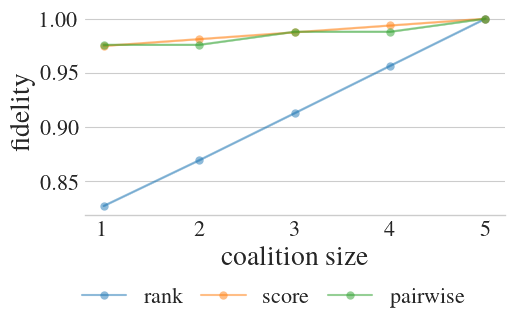

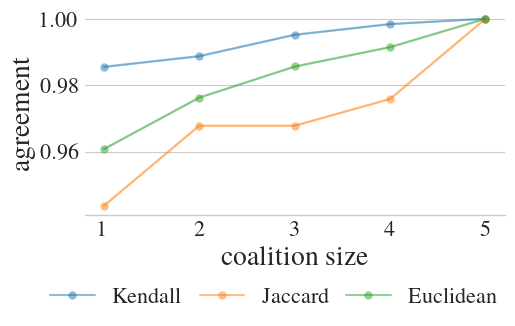

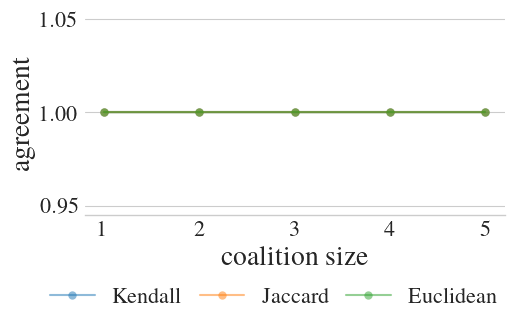

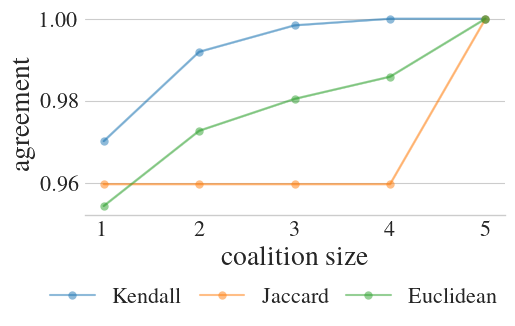

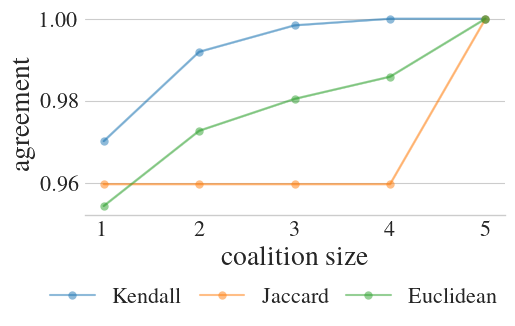

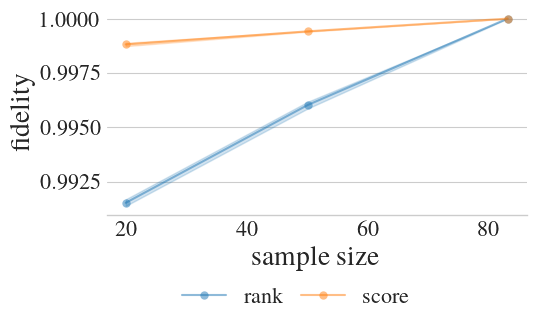

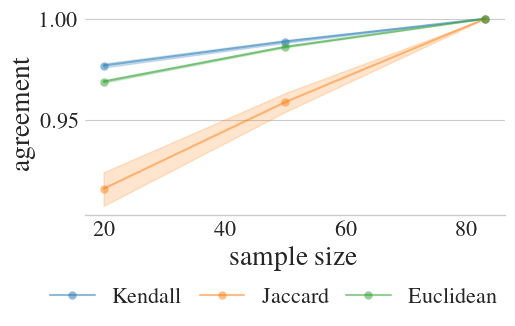

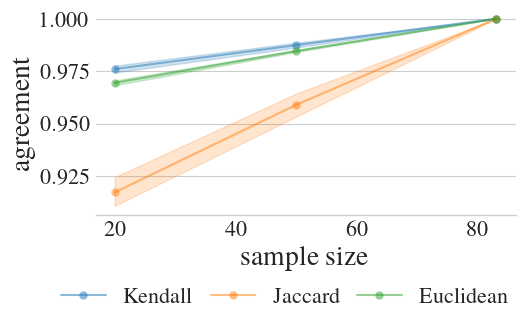

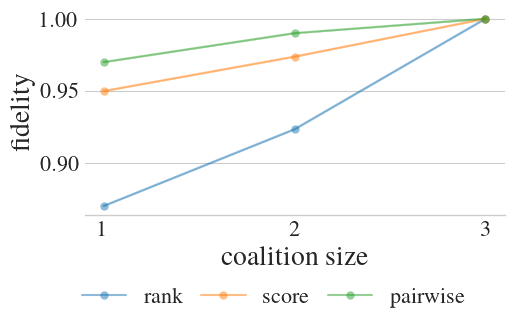

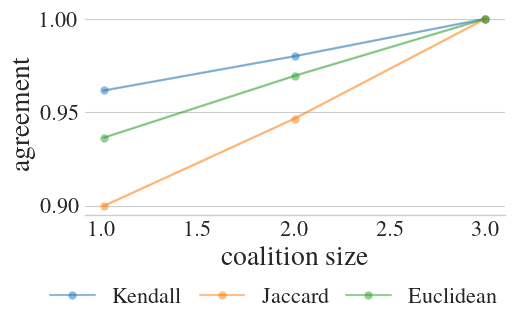

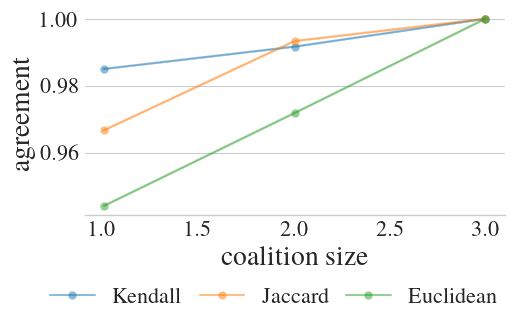

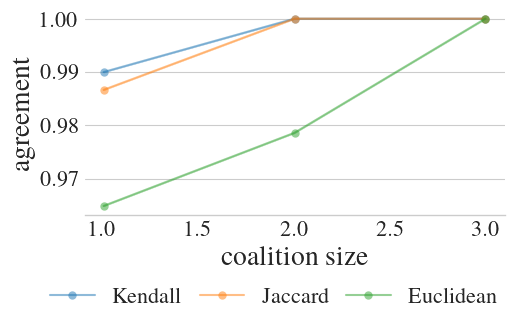

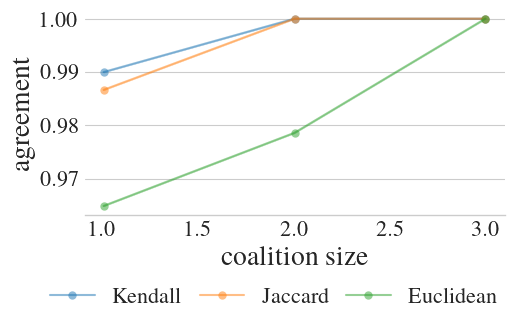

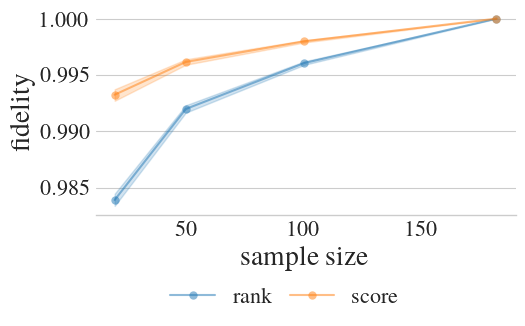

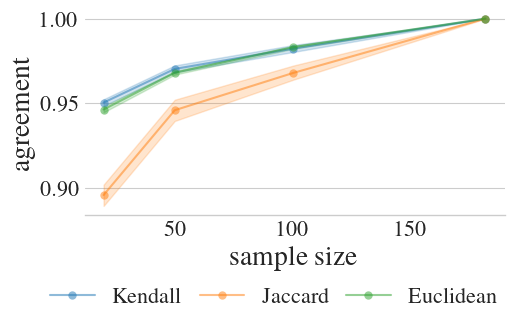

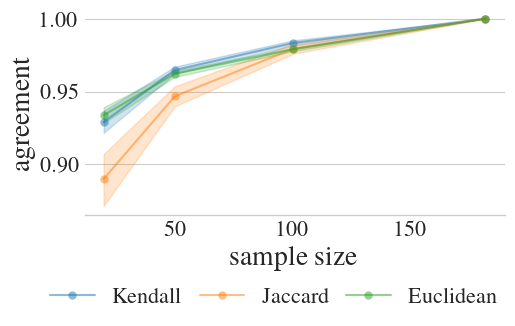

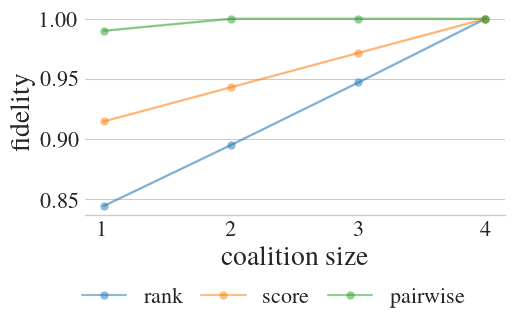

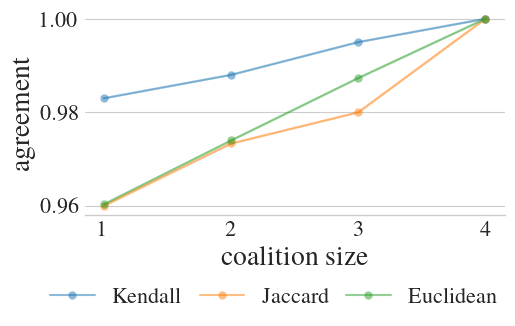

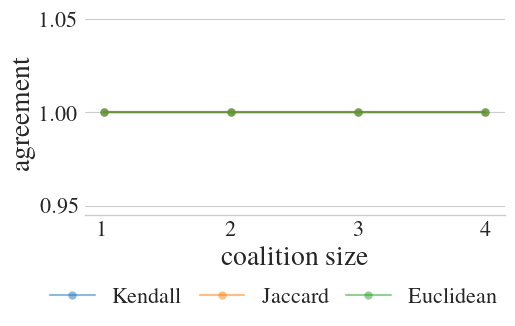

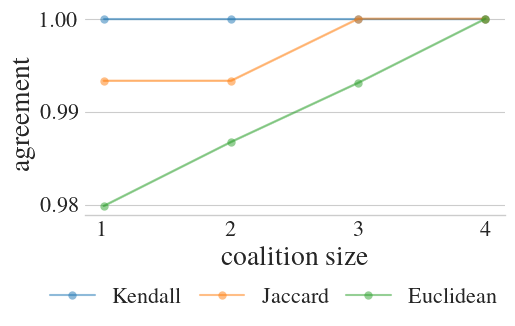

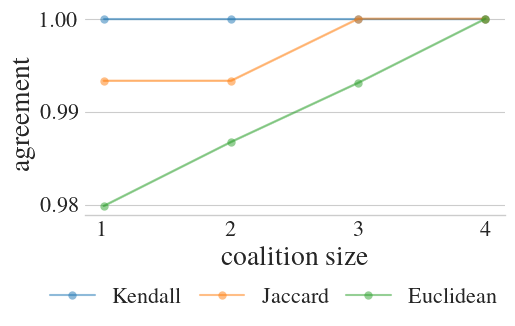

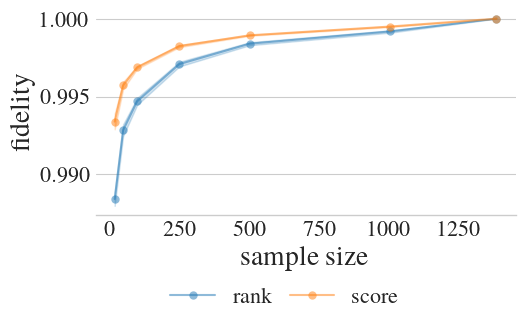

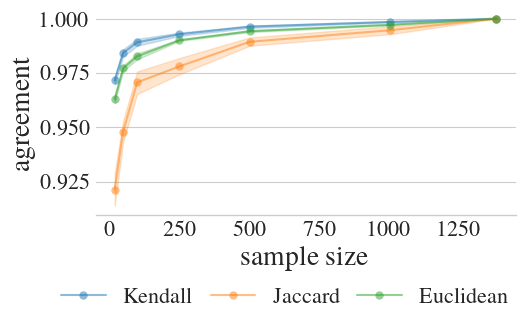

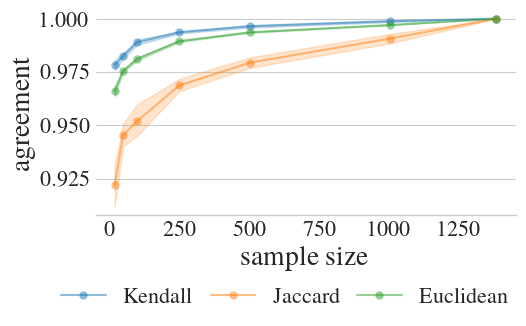

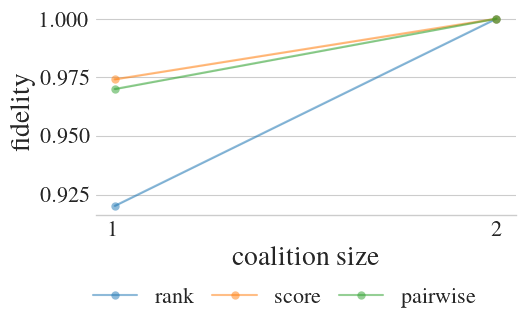

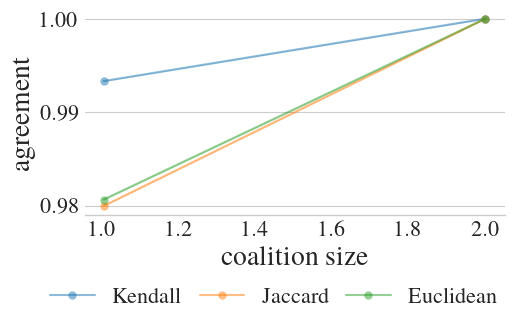

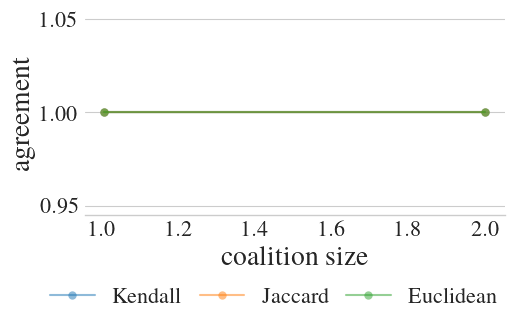

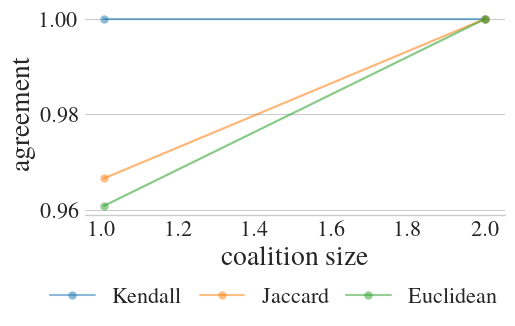

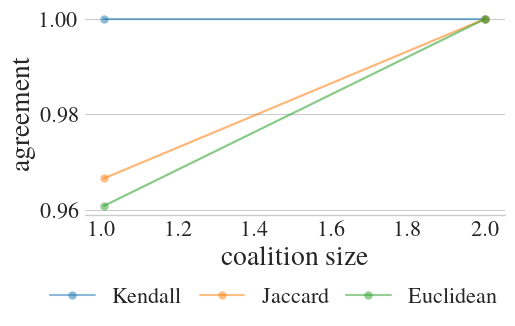

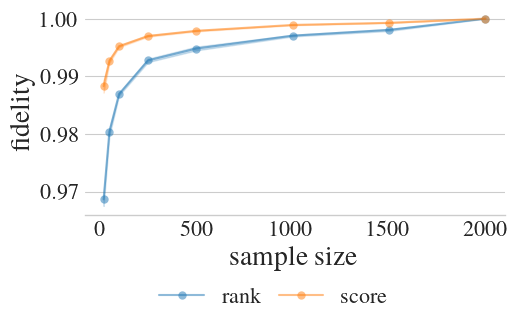

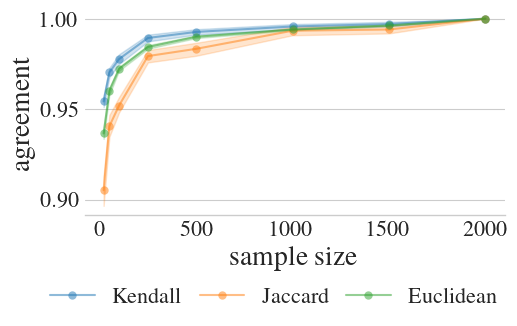

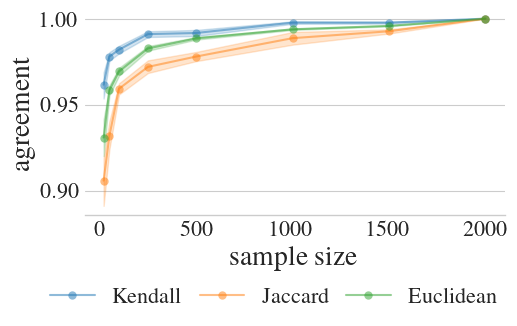

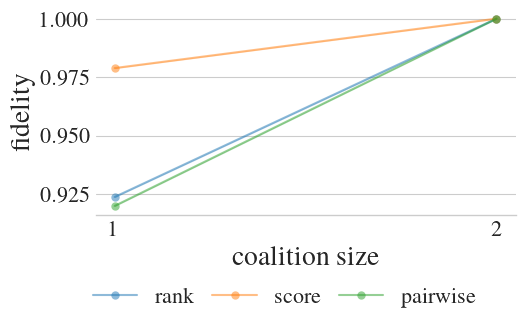

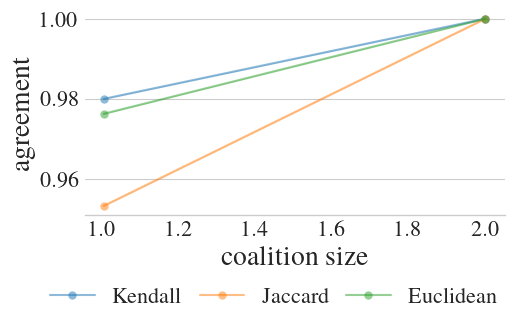

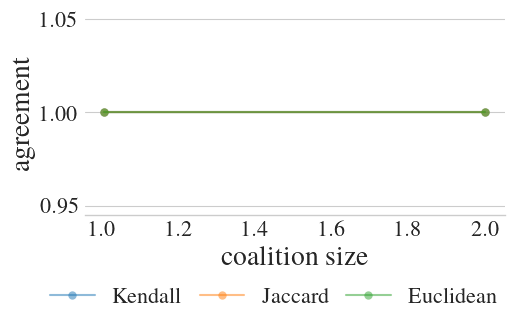

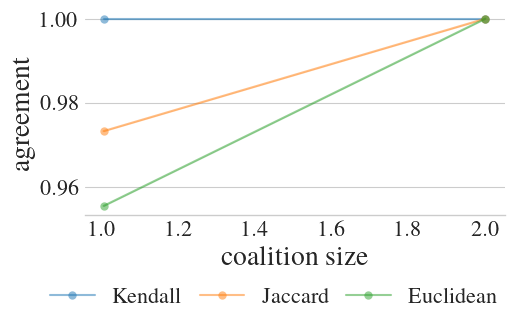

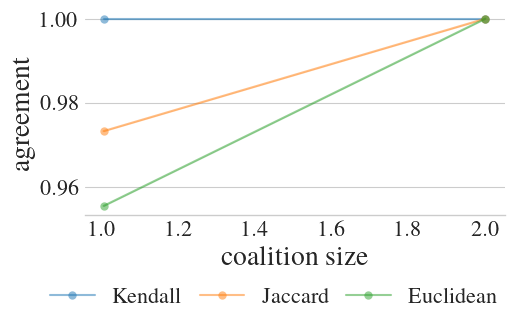

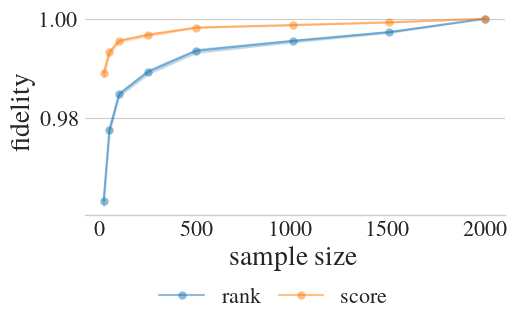

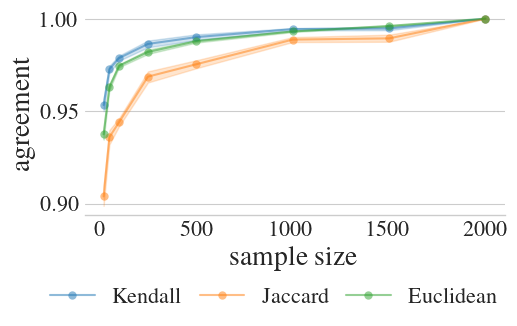

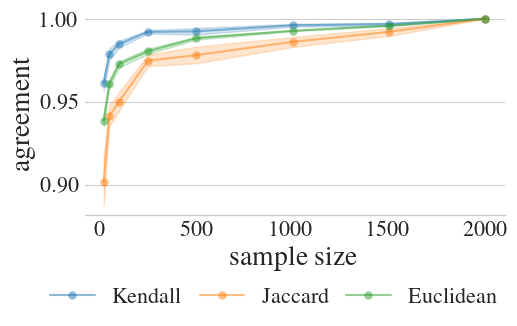

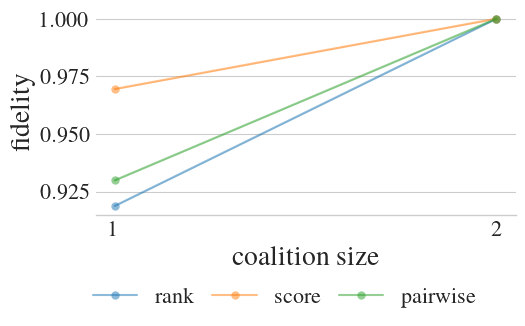

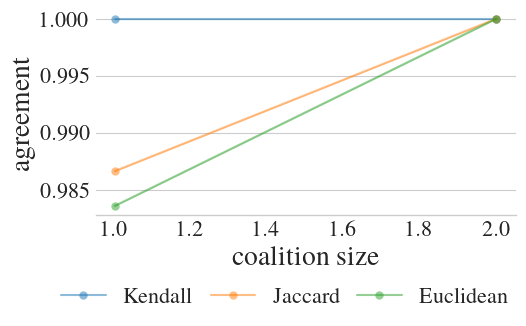

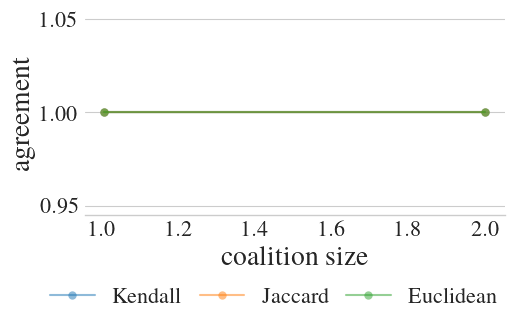

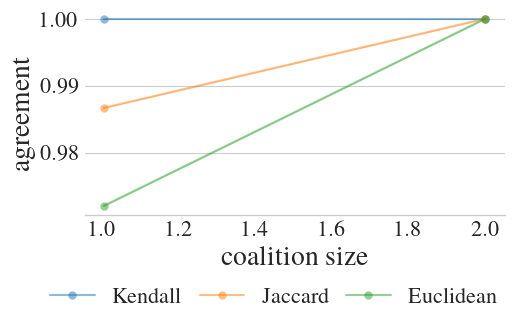

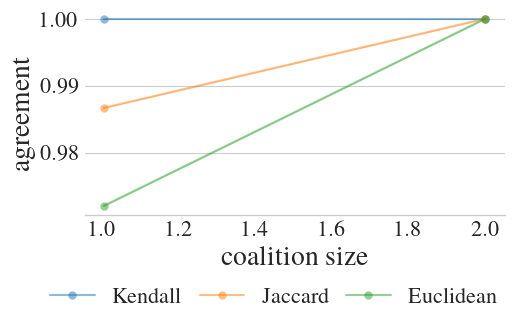

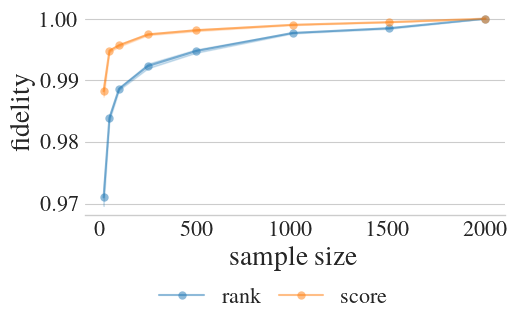

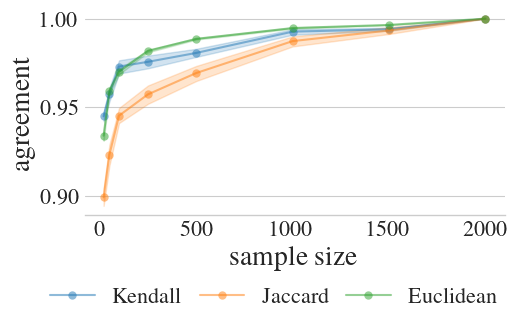

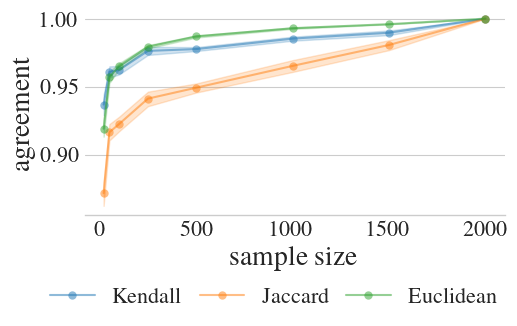

In [155]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]
distance_mapper = {
    "kendall's tau": "Kendall",
    "Jaccard Index Top-2": "Jaccard",
    "Euclidean distance": "Euclidean",
}

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"] == dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(
        lambda row: (
            "Pairwise " + row["QoI"].capitalize()
            if row["pairwise"]
            else row["QoI"].capitalize()
        ),
        axis=1,
    )
    df = df[df["QoI"] != "Pairwise Score"]
    df["QoI"] = df["QoI"].str.replace("Pairwise Rank", "pairwise").str.lower()
    df.drop(columns=["pairwise"], inplace=True)
    df["Distance Metric"] = df["Distance Metric"].map(distance_mapper)
    df.rename(
        columns={"# coalitions": "coalition size", "# samples": "sample size"},
        inplace=True,
    )

    for approach, approach_name in zip(
        ["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]
    ):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"] == approach].copy()
        # df_coals.columns = df.columns.str.replace("#", r"\#")
        # print(df_coals)

        # Fidelity plot
        fig, ax = plt.subplots(figsize=(5, 2.5))
        plt.grid(axis="x")
        if approach == "coalition_size":
            sns.lineplot(
                x="coalition size",
                y="fidelity",
                hue="QoI",
                data=df_coals,
                alpha=0.5,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xticks(df_coals["coalition size"].unique().astype(int))
            plt.xlabel("coalition size")
            plt.ylabel("fidelity")
        else:
            sns.lineplot(
                x="sample size",
                y="fidelity",
                hue="QoI",
                data=df_coals,
                alpha=0.5,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xlabel("sample size")
            plt.ylabel("fidelity")
            # plt.xticks(df_coals['sample size'].unique().astype(int))

        plt.legend(
            bbox_to_anchor=(0.45, -0.25),
            ncol=len(df_coals["QoI"].unique()),
            loc="upper center",
            columnspacing=0.8,
            title="",
        )
        plt.savefig(
            f"results/time/plots/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True,
        )
        plt.show()

        # Method Agreement
        if approach == "coalition_size":
            # fig, ax = plt.subplots(nrows=2, ncols=2, sharey='all', figsize=(16, 12))
            x_var = "coalition size"
        else:
            # fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all', figsize=(16, 6))
            x_var = "sample size"

        # ax = ax.ravel()

        # Rank lines
        fig, ax = plt.subplots(figsize=(5, 2.5))
        plt.grid(axis="x")
        temp = df_coals[df_coals["QoI"] == "rank"]
        sns.lineplot(
            x=x_var,
            y="agreement",
            hue="Distance Metric",
            data=temp,
            alpha=0.5,
            ax=ax,
            marker="o",
            markeredgewidth=0.0,
        )
        plt.xlabel(x_var.lower())
        plt.ylabel("agreement")
        plt.legend(
            bbox_to_anchor=(0.45, -0.25),
            ncol=len(temp["Distance Metric"].unique()),
            loc="upper center",
            columnspacing=0.8,
            title="",
        )
        plt.savefig(
            f"results/time/plots/time-experiment-{approach}-agreement-{dataset["name"]}_rank.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True,
        )
        plt.show()

        # Score lines
        fig, ax = plt.subplots(figsize=(5, 2.5))
        plt.grid(axis="x")
        temp = df_coals[df_coals["QoI"] == "score"]
        sns.lineplot(
            x=x_var,
            y="agreement",
            hue="Distance Metric",
            data=temp,
            alpha=0.5,
            ax=ax,
            marker="o",
            markeredgewidth=0.0,
        )
        plt.xlabel(x_var.lower())
        plt.ylabel("agreement")
        plt.legend(
            bbox_to_anchor=(0.45, -0.25),
            ncol=len(temp["Distance Metric"]),
            loc="upper center",
            columnspacing=0.8,
            title="",
        )
        plt.savefig(
            f"results/time/plots/time-experiment-{approach}-agreement-{dataset["name"]}_score.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True,
        )
        plt.show()

        # Pairwise lines
        if approach == "coalition_size":
            # Rank lines
            fig, ax = plt.subplots(figsize=(5, 2.5))
            plt.grid(axis="x")
            temp = df_coals[df_coals["QoI"] == "pairwise"]
            sns.lineplot(
                x=x_var,
                y="agreement",
                hue="Distance Metric",
                data=temp,
                alpha=0.5,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xlabel(x_var.lower())
            plt.ylabel("agreement")
            plt.legend(
                bbox_to_anchor=(0.45, -0.25),
                ncol=len(temp["Distance Metric"].unique()),
                loc="upper center",
                columnspacing=0.8,
                title="",
            )
            plt.savefig(
                f"results/time/plots/time-experiment-{approach}-agreement-{dataset["name"]}_pairwise_rank.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True,
            )
            plt.show()

            # Score lines
            fig, ax = plt.subplots(figsize=(5, 2.5))
            plt.grid(axis="x")
            temp = df_coals[df_coals["QoI"] == "pairwise"]
            sns.lineplot(
                x=x_var,
                y="agreement",
                hue="Distance Metric",
                data=temp,
                alpha=0.5,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xlabel(x_var.lower())
            plt.ylabel("agreement")
            plt.legend(
                bbox_to_anchor=(0.45, -0.25),
                ncol=len(temp["Distance Metric"].unique()),
                loc="upper center",
                columnspacing=0.8,
                title="",
            )
            plt.savefig(
                f"results/time/plots/time-experiment-{approach}-agreement-{dataset["name"]}_pairwise_score.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True,
            )
            plt.show()

In [12]:
# methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# for dataset in datasets:
#     # Plot dataset only
#     df = df_all[df_all["dataset"]== dataset["name"]]

#     for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

# Make plots separately per dataset per approach
# df_coals = df[df["parameter"]==approach]
# # average fidelity
# df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
# # average agreement
# df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4']].mean(axis=1)
# df_coals['average_agreement_jaccard'] = df_coals[['agreement_jaccard2_0', 'agreement_jaccard2_1', 'agreement_jaccard2_2', 'agreement_jaccard2_3', 'agreement_jaccard2_4']].mean(axis=1)
# df_coals['average_agreement_euclidean'] = df_coals[['agreement_euclidean_0', 'agreement_euclidean_1', 'agreement_euclidean_2', 'agreement_euclidean_3', 'agreement_euclidean_4']].mean(axis=1)

# # Fidelity plot
# plt.plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"]['average_fidelity'], marker='o', label='rank',alpha=0.5)
# plt.plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"]['average_fidelity'], marker='o', label='score',alpha=0.5)
# if approach == "coalition_size":
#     plt.plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"]['average_fidelity'], marker='o', label='pairwise rank',alpha=0.5)
#     plt.plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"]['average_fidelity'], marker='o', label='pairwise score',alpha=0.5)


# plt.xlabel(approach_name)
# plt.ylabel('Method Fidelity')
# # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
# plt.legend(title='QoI')
# if approach == "coalition_size":
#     plt.xticks(df_coals['parameter_value'].unique().astype(int))

# # plt.xticks(coalition_data['parameter_value'].unique().astype(int))

# plt.savefig(
#         f"results/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
#         format="pdf",
#         bbox_inches="tight",
#         transparent=True
#         )

# plt.show()

# # Method Agreement
# if approach == "coalition_size":
#     fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(16, 12))
# else:
#     fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(16, 6))

# ax = ax.ravel()

# # Rank lines
# for agreement in ['kendall', 'jaccard', 'euclidean']:
#     ax[0].plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

# ax[0].set_xlabel(approach_name)
# ax[0].set_ylabel('Method Agreement')
# if approach == "coalition_size":
#     ax[0].set_xticks(df_coals['parameter_value'].unique().astype(int))


# # Score lines
# for agreement in ['kendall', 'jaccard', 'euclidean']:
#     ax[1].plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

# ax[1].yaxis.set_tick_params(which='both', labelleft=True)
# ax[1].set_xlabel(approach_name)
# ax[1].set_ylabel('Method Agreement')
# if approach == "coalition_size":
#     ax[1].set_xticks(df_coals['parameter_value'].unique().astype(int))


# # Pairwise lines
# if approach == "coalition_size":
#     for agreement in ['kendall', 'jaccard', 'euclidean']:
#         ax[2].plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

#     ax[2].yaxis.set_tick_params(which='both', labelleft=True)
#     ax[2].set_xlabel(approach_name)
#     ax[2].set_ylabel('Method Agreement')
#     ax[2].set_xticks(df_coals['parameter_value'].unique().astype(int))

#     for agreement in ['kendall', 'jaccard', 'euclidean']:
#             ax[3].plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

#     ax[3].yaxis.set_tick_params(which='both', labelleft=True)
#     ax[3].set_xlabel(approach_name)
#     ax[3].set_ylabel('Method Agreement')
#     ax[3].set_xticks(df_coals['parameter_value'].unique().astype(int))


# # plt.title(f'{approach_name} vs Agreement for {dataset["name"]}')
# plt.legend(title='Metric')

# plt.savefig(
#         f"results/time-experiment-{approach}-agreement-{dataset["name"]}.pdf",
#         format="pdf",
#         bbox_inches="tight",
#         transparent=True
#         )

# plt.show()

# Time vs coalition size

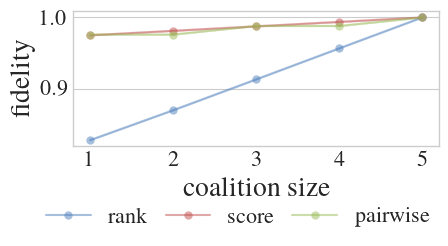

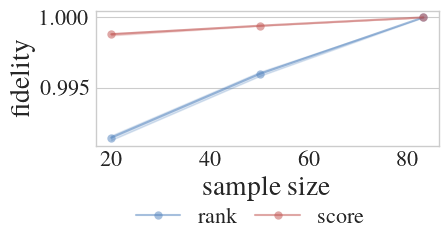

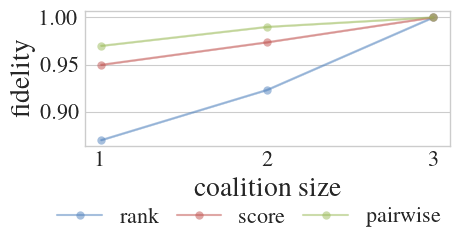

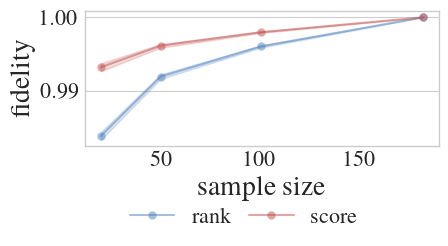

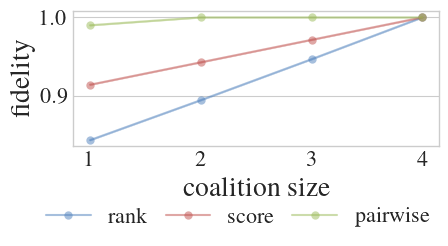

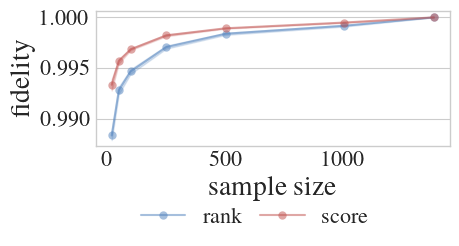

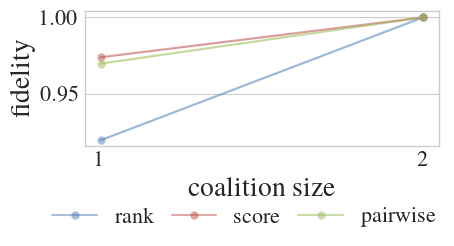

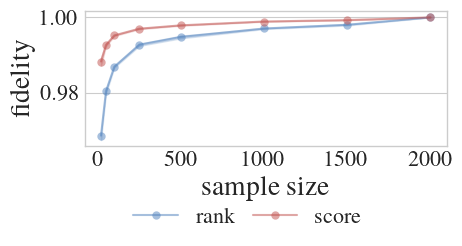

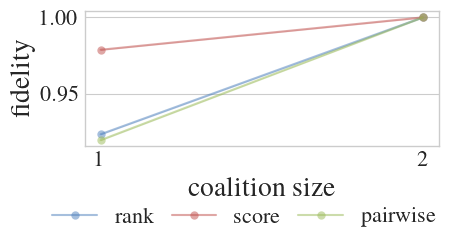

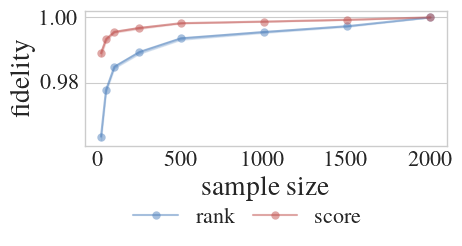

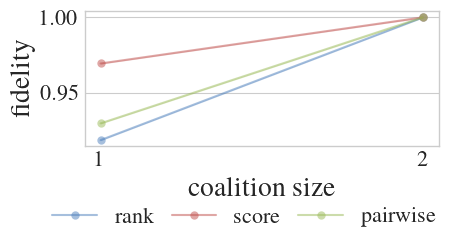

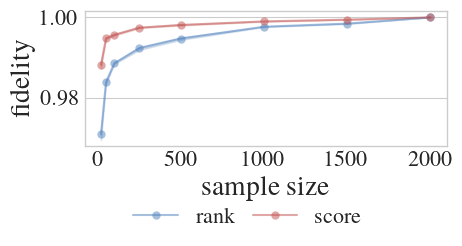

In [21]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

colors = {
    "rank": "#4f81bd",
    "score": "#c0504d",
    "pairwise": "#9bbb59",
}

distance_mapper = {
    "kendall's tau": "Kendall",
    "Jaccard Index Top-2": "Jaccard",
    "Euclidean distance": "Euclidean",
}

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"] == dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(
        lambda row: (
            "Pairwise " + row["QoI"].capitalize()
            if row["pairwise"]
            else row["QoI"].capitalize()
        ),
        axis=1,
    )
    df = df[df["QoI"] != "Pairwise Score"]
    df["QoI"] = df["QoI"].str.replace("Pairwise Rank", "pairwise").str.lower()
    df.drop(columns=["pairwise"], inplace=True)
    df["Distance Metric"] = df["Distance Metric"].map(distance_mapper)
    df.rename(
        columns={"# coalitions": "coalition size", "# samples": "sample size"},
        inplace=True,
    )

    for approach, approach_name in zip(
        ["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]
    ):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"] == approach]
        # print(df_coals)

        fig, ax = plt.subplots(figsize=(5, 2.5))

        # Fidelity plot
        if approach == "coalition_size":
            sns.lineplot(
                x="coalition size",
                y="fidelity",
                hue="QoI",
                data=df_coals,
                alpha=0.5,
                palette=colors,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xlabel("coalition size")
            plt.xticks(df_coals["coalition size"].unique().astype(int))
        else:
            sns.lineplot(
                x="sample size",
                y="fidelity",
                hue="QoI",
                data=df_coals,
                alpha=0.5,
                palette=colors,
                ax=ax,
                marker="o",
                markeredgewidth=0.0,
            )
            plt.xlabel("sample size")
            # plt.xticks(df_coals['# samples'].unique().astype(int))

        plt.tight_layout()
        plt.grid(axis="x")
        plt.ylabel("fidelity")
        plt.legend(
            bbox_to_anchor=(0.45, -0.3),
            ncol=len(df_coals["QoI"].unique()),
            loc="upper center",
            columnspacing=0.8,
            title="",
        )
        plt.savefig(
            f"results/time/plots/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True,
        )

        plt.show()

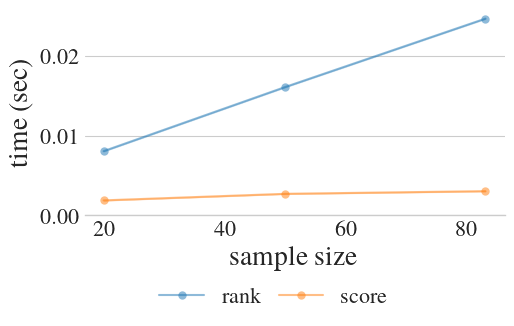

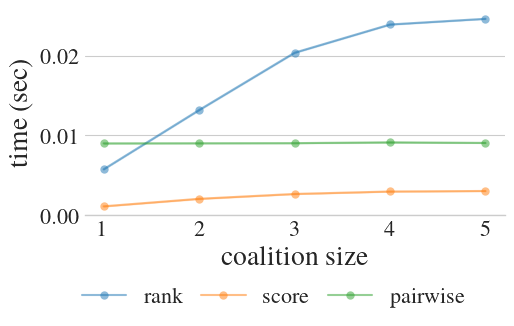

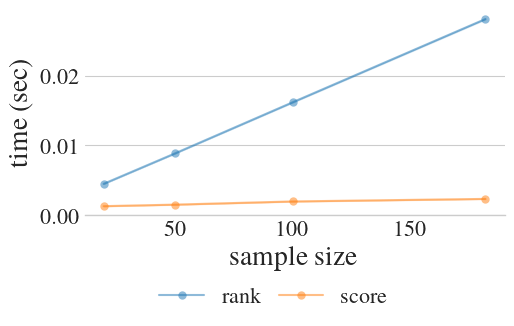

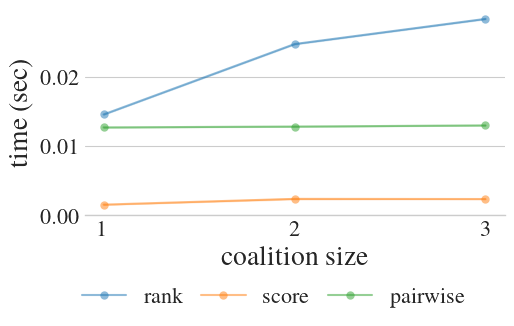

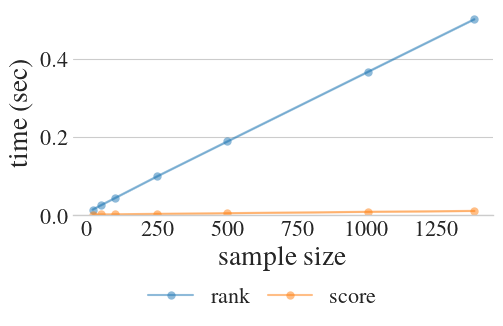

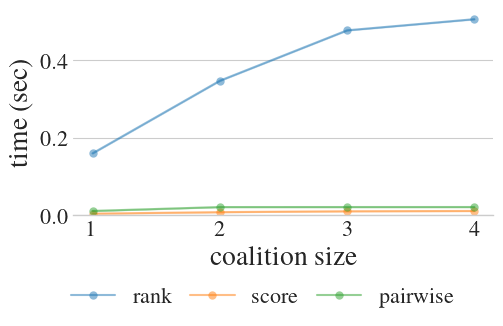

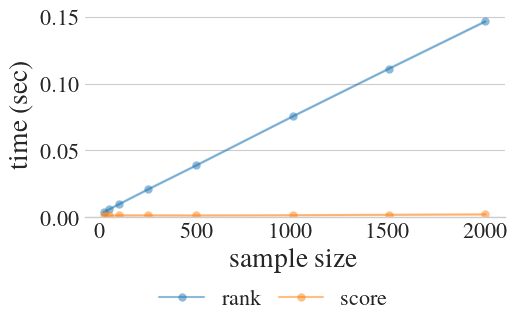

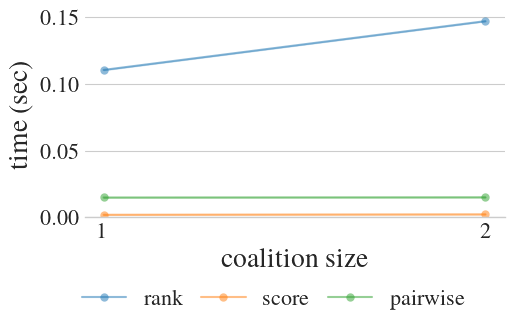

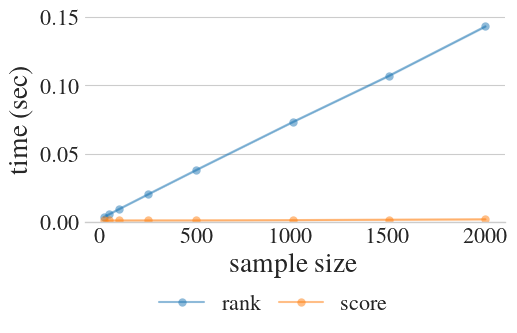

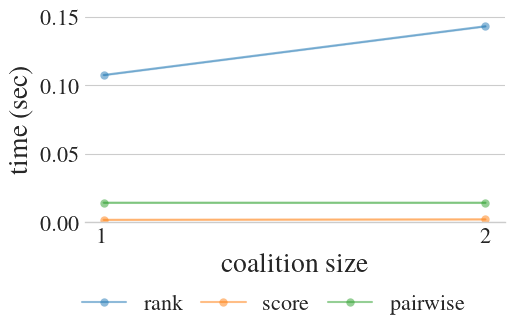

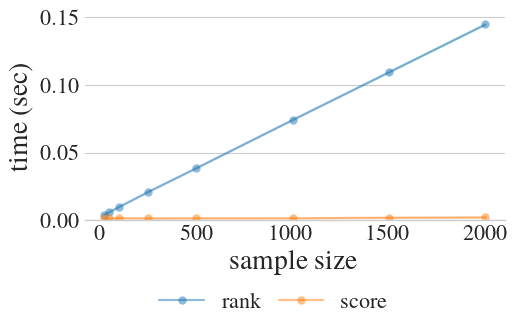

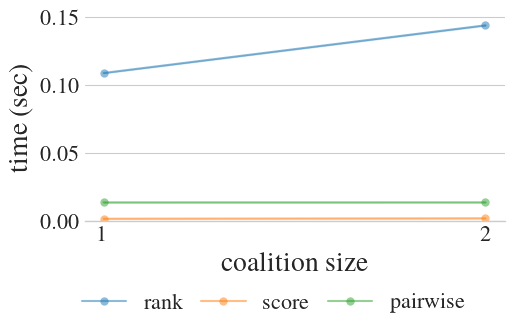

In [157]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = df_all[df_all["dataset"] == dataset["name"]].copy()
    df.rename(columns={"distance metric": "Distance Metric"}, inplace=True)
    df["QoI"] = df.apply(
        lambda row: (
            "Pairwise " + row["QoI"].capitalize()
            if row["pairwise"]
            else row["QoI"].capitalize()
        ),
        axis=1,
    )
    df = df[df["QoI"] != "Pairwise Score"]
    df["QoI"] = df["QoI"].str.replace("Pairwise Rank", "pairwise").str.lower()
    df.drop(columns=["pairwise"], inplace=True)
    df["Distance Metric"] = df["Distance Metric"].map(distance_mapper)
    df.rename(
        columns={"# coalitions": "coalition size", "# samples": "sample size"},
        inplace=True,
    )

    # Sample plot
    df_samples = df[df["parameter"] == "sample_size"]
    # print(df_samples)

    fig, ax = plt.subplots(figsize=(5, 2.5))
    sns.lineplot(
        x="sample size",
        y="time",
        hue="QoI",
        data=df_samples,
        alpha=0.5,
        ax=ax,
        marker="o",
        markeredgewidth=0.0,
    )

    plt.xlabel("sample size")
    plt.ylabel("time (sec)")
    plt.ylim(0)
    plt.legend(
        bbox_to_anchor=(0.45, -0.25),
        ncol=len(df_samples["QoI"].unique()),
        loc="upper center",
        columnspacing=0.8,
        title="",
    )
    plt.grid(axis="x")
    plt.savefig(
        f"results/time-experiment-timeNsamples-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

    # Coalition plot
    df_coals = df[df["parameter"] == "coalition_size"]
    # print(df_coals)

    fig, ax = plt.subplots(figsize=(5, 2.5))
    sns.lineplot(
        x="coalition size",
        y="time",
        hue="QoI",
        data=df_coals,
        alpha=0.5,
        ax=ax,
        marker="o",
        markeredgewidth=0.0,
    )
    plt.xticks(df_coals["coalition size"].unique().astype(int))

    plt.xlabel("coalition size")
    plt.ylabel("time (sec)")
    plt.ylim(0)
    plt.legend(
        bbox_to_anchor=(0.45, -0.25),
        ncol=len(df_coals["QoI"].unique()),
        loc="upper center",
        columnspacing=0.8,
        title="",
    )
    plt.grid(axis="x")
    plt.savefig(
        f"results/time/plots/time-experiment-timeNcoalition-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

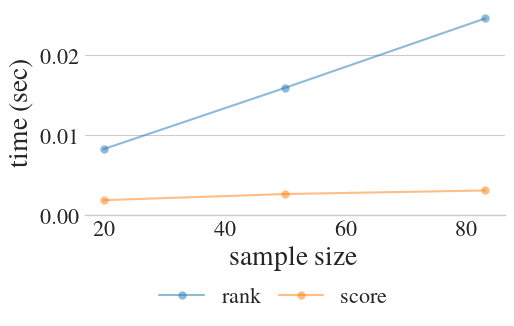

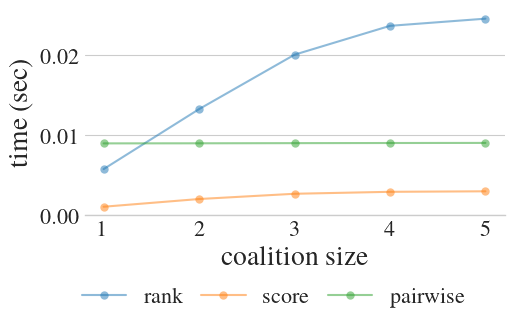

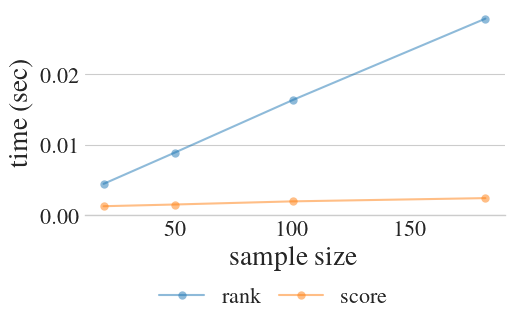

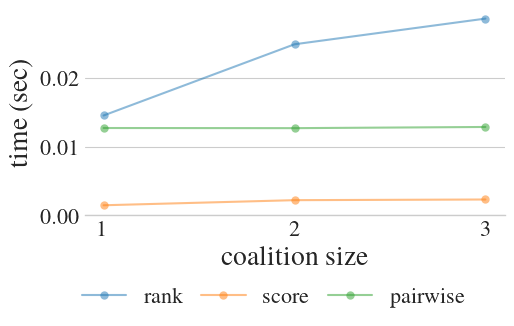

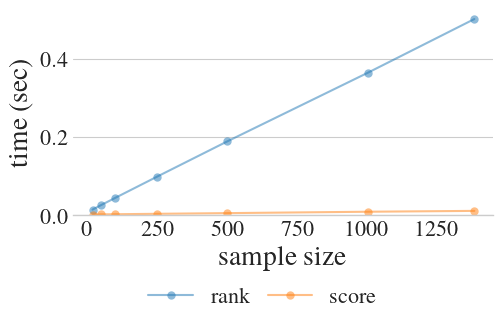

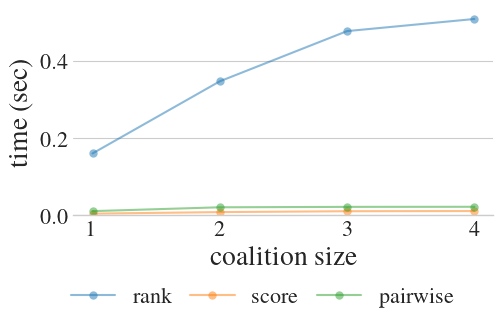

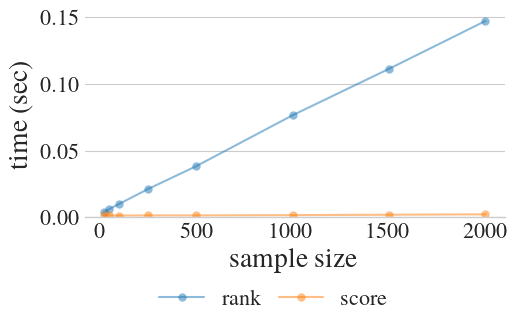

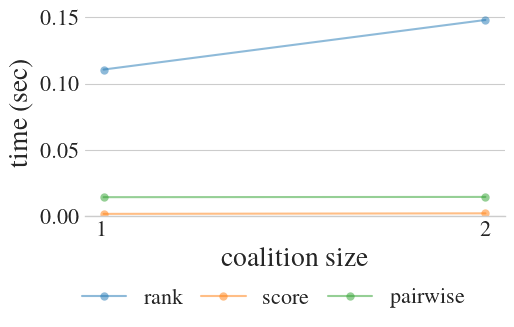

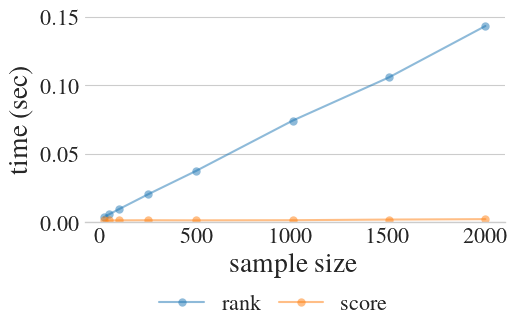

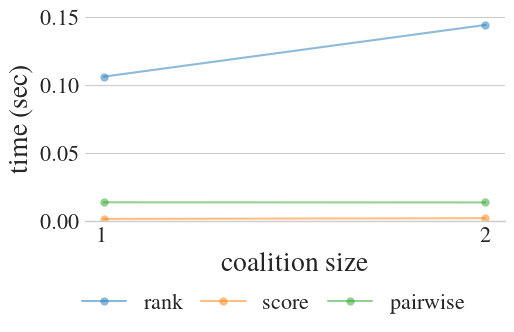

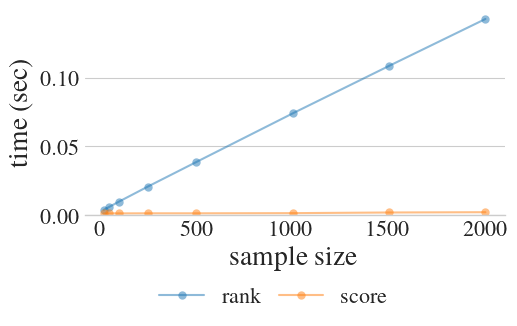

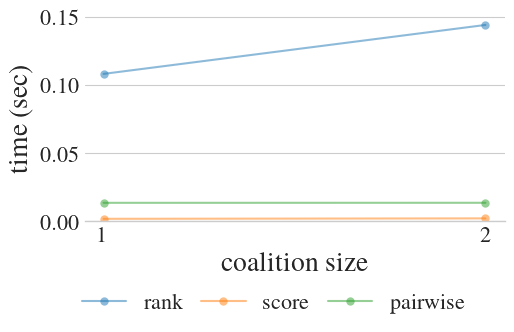

In [185]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Get dataset size
    n_samples = dataset["data"][0].shape[1]
    n_features = dataset["data"][0].shape[0]

    # Sample plot
    df = pd.DataFrame()
    for method in methods:
        # Sample experiments
        tmp = results[dataset["name"]][method][0].copy()
        if not tmp.empty:
            tmp = tmp[tmp["parameter"] == "sample_size"]
            tmp = tmp.dropna()
            tmp["time"] = tmp["time_0"] / 100
            # Set new columns
            tmp["# samples"] = tmp["parameter_value"]
            tmp["# coalitions"] = n_features
            tmp.drop(
                columns=[
                    "time_0",
                    "time_1",
                    "time_2",
                    "time_3",
                    "time_4",
                    "agreement_kendall_0",
                    "agreement_kendall_1",
                    "agreement_kendall_2",
                    "agreement_kendall_3",
                    "agreement_kendall_4",
                    "agreement_jaccard2_0",
                    "agreement_jaccard2_1",
                    "agreement_jaccard2_2",
                    "agreement_jaccard2_3",
                    "agreement_jaccard2_4",
                    "agreement_euclidean_0",
                    "agreement_euclidean_1",
                    "agreement_euclidean_2",
                    "agreement_euclidean_3",
                    "agreement_euclidean_4",
                    "fidelity_0",
                    "fidelity_1",
                    "fidelity_2",
                    "fidelity_3",
                    "fidelity_4",
                    "n_observations",
                    "parameter",
                    "parameter_value",
                    "avg_time",
                ],
                inplace=True,
            )
            df = pd.concat([df, tmp])
            df = df.replace("rank_score_rank_score", "Score")
            df = df.replace("rank_rank", "Rank")
            df = df.replace("pairwise_rank_score", "Pairwise Score")
            df = df.replace("pairwise_rank", "Pairwise Rank")

    df = df[df["approach"] != "Pairwise Score"].copy()
    df["approach"] = df["approach"].str.replace("Pairwise Rank", "pairwise").str.lower()
    df.rename(
        columns={"# coalitions": "coalition size", "# samples": "sample size"},
        inplace=True,
    )

    # Sample plot
    df_coals = df
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.plot(
        df_coals[df_coals["approach"] == "rank"]["sample size"],
        df_coals[df_coals["approach"] == "rank"]["time"],
        label="rank",
        alpha=0.5,
        marker="o",
        markeredgewidth=0.0,
    )
    ax.plot(
        df_coals[df_coals["approach"] == "score"]["sample size"],
        df_coals[df_coals["approach"] == "score"]["time"],
        label="score",
        alpha=0.5,
        marker="o",
        markeredgewidth=0.0,
    )

    plt.xlabel("sample size")
    plt.ylabel("time (sec)")

    plt.ylim(0)
    plt.legend(
        bbox_to_anchor=(0.45, -0.25),
        ncol=2,
        loc="upper center",
        columnspacing=0.8,
        title="",
    )
    plt.grid(axis="x")
    plt.savefig(
        f"results/time-experiment-{approach}-timeNsamples-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

    # print(df)

    # Coalition plot
    df = pd.DataFrame()
    for method in methods:
        # Coalition experiments
        tmp = results[dataset["name"]][method][0].copy()
        if not tmp.empty:
            tmp = tmp[tmp["parameter"] == "coalition_size"]
            tmp = tmp.dropna()
            tmp["time"] = tmp["time_0"] / 100
            # Set new columns
            tmp["# samples"] = n_samples
            tmp["# coalitions"] = tmp["parameter_value"]
            tmp.drop(
                columns=[
                    "time_0",
                    "time_1",
                    "time_2",
                    "time_3",
                    "time_4",
                    "agreement_kendall_0",
                    "agreement_kendall_1",
                    "agreement_kendall_2",
                    "agreement_kendall_3",
                    "agreement_kendall_4",
                    "agreement_jaccard2_0",
                    "agreement_jaccard2_1",
                    "agreement_jaccard2_2",
                    "agreement_jaccard2_3",
                    "agreement_jaccard2_4",
                    "agreement_euclidean_0",
                    "agreement_euclidean_1",
                    "agreement_euclidean_2",
                    "agreement_euclidean_3",
                    "agreement_euclidean_4",
                    "fidelity_0",
                    "fidelity_1",
                    "fidelity_2",
                    "fidelity_3",
                    "fidelity_4",
                    "n_observations",
                    "parameter",
                    "parameter_value",
                    "avg_time",
                ],
                inplace=True,
            )

            # Make dataset that contains all methods together (if run each QoI separately)
            df = pd.concat([df, tmp])
            df = df.replace("rank_score_rank_score", "Score")
            df = df.replace("rank_rank", "Rank")
            df = df.replace("pairwise_rank_score", "Pairwise Score")
            df = df.replace("pairwise_rank", "Pairwise Rank")

    df = df[df["approach"] != "Pairwise Score"].copy()
    df["approach"] = df["approach"].str.replace("Pairwise Rank", "pairwise").str.lower()
    df.rename(
        columns={"# coalitions": "coalition size", "# samples": "sample size"},
        inplace=True,
    )

    # Coalition plot
    df_coals = df
    # df_coals = df_coals[df_coals["# coalitions"] != n_features]
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.plot(
        df_coals[df_coals["approach"] == "rank"]["coalition size"],
        df_coals[df_coals["approach"] == "rank"]["time"],
        label="rank",
        alpha=0.5,
        marker="o",
        markeredgewidth=0.0,
    )
    ax.plot(
        df_coals[df_coals["approach"] == "score"]["coalition size"],
        df_coals[df_coals["approach"] == "score"]["time"],
        label="score",
        alpha=0.5,
        marker="o",
        markeredgewidth=0.0,
    )
    ax.plot(
        df_coals[df_coals["approach"] == "pairwise"]["coalition size"],
        df_coals[df_coals["approach"] == "pairwise"]["time"],
        label="pairwise",
        alpha=0.5,
        marker="o",
        markeredgewidth=0.0,
    )

    plt.xlabel("coalition size")
    plt.ylabel("time (sec)")
    # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
    plt.xticks(df_coals["coalition size"].unique().astype(int))

    plt.ylim(0)
    plt.legend(
        bbox_to_anchor=(0.45, -0.25),
        ncol=3,
        loc="upper center",
        columnspacing=0.8,
        title="",
    )
    plt.grid(axis="x")
    plt.savefig(
        f"results/time-experiment-{approach}-timeNcoalition-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

    # print(df_coals)